In [ ]:
# !git clone https://github.com/MCG-NJU/VideoMAE.git

In [ ]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install timm==0.4.12
# !DS_BUILD_OPS=1 pip install deepspeed==0.5.8
# !pip install tensorboardX
# !pip install decord
# !pip install einops

In [ ]:
# # Set the path to save video
# OUTPUT_DIR='/content/'
# # path to video for visualization
# VIDEO_PATH='/content/video.mp4'
# # path to pretrain model
# MODEL_PATH='/content/checkpoint.pth'

# !python3 /content/VideoMAE/run_videomae_vis.py \
#     --mask_ratio 0.9 \
#     --mask_type tube \
#     --decoder_depth 4 \
#     --model pretrain_videomae_base_patch16_224 \
#     {VIDEO_PATH} {OUTPUT_DIR} {MODEL_PATH}

In [ ]:
!pip install av -q

import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel
from transformers import AutoImageProcessor, TimesformerModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

file_path = '/content/video.mp4'
container = av.open(file_path)

indices = sample_frame_indices(clip_len=32, frame_sample_rate=3, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
from transformers import VivitConfig

config = VivitConfig.from_pretrained("google/vivit-b-16x2-kinetics400")
config.variant = "factorised_encoder"

# Sau đó tải model với config đã cập nhật
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", config=config)

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

import torch

# Chuyển model lên GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

# Chuyển inputs lên GPU và thực hiện forward pass
inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions

# Chuyển attentions về CPU
attentions = [att.cpu() for att in attentions]

last_layer_attentions = attentions[-1]
print(last_layer_attentions.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
VivitSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attenti

torch.Size([1, 12, 3137, 3137])


In [ ]:
indices

array([ 44,  47,  50,  53,  56,  59,  62,  65,  68,  71,  74,  78,  81,
        84,  87,  90,  93,  96,  99, 102, 105, 109, 112, 115, 118, 121,
       124, 127, 130, 133, 136, 139])

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

last_attentions = outputs.attentions[-1]

# Giả sử batch size B = 1 (một video)
attn = last_attentions[0]  # shape: (num_heads, seq_len, seq_len)

# Trích xuất attention từ token CLS (index 0) đến các token video (bỏ qua token CLS)
cls_attn = attn[:, 0, 1:]  # shape: (num_heads, seq_len - 1)
# Trung bình qua các head
avg_cls_attn = cls_attn.mean(dim=0)  # shape: (seq_len - 1,)

# Với ViViT "google/vivit-b-16x2-kinetics400", tubelet_size = 2 và
# mỗi tubelet có 196 token (với spatial grid 14x14), do đó:
total_tokens = avg_cls_attn.shape[0]  # nên bằng tubelet_count * 196
tubelet_count = total_tokens // 196  # ví dụ: 32 frames -> 16 tubelets
print("Total tokens:", total_tokens, "Tubelet count:", tubelet_count)

# Tạo heatmap cho từng tubelet
tubelet_heatmaps = []
for t in range(tubelet_count):
    # Lấy trọng số attention cho tubelet t (196 token)
    token_attn = avg_cls_attn[t*196:(t+1)*196]  # shape: (196,)
    # Chuẩn hóa
    token_attn = (token_attn - token_attn.min()) / (token_attn.max() - token_attn.min() + 1e-8)
    # Reshape thành lưới 14x14
    attn_grid = token_attn.reshape(14, 14)
    # Chuyển sang tensor và thêm batch, channel để interpolate
    attn_tensor = torch.tensor(attn_grid).unsqueeze(0).unsqueeze(0)  # (1,1,14,14)
    # Phóng to lên kích thước 224x224
    attn_up = F.interpolate(attn_tensor, size=(224, 224), mode="bilinear", align_corners=False)
    heatmap = attn_up.squeeze().cpu().numpy()  # (224,224), giá trị trong [0,1]
    tubelet_heatmaps.append(heatmap)

overlay_frames = [] # Reset overlay_frames
num_frames = video.shape[0]  # 32 frame
for t in range(tubelet_count):
    # Lấy heatmap của tubelet t, chuyển về [0,255] và uint8
    heatmap = (tubelet_heatmaps[t] * 255).astype(np.uint8)
    # Sử dụng colormap (ở đây dùng COLORMAP_INFERNO)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize heatmap_color to match the size of the frame
    heatmap_color_resized = cv2.resize(heatmap_color, (video[0].shape[1], video[0].shape[0])) # Resize heatmap

    # Mỗi tubelet ứng với 2 frame: lấy frame thứ 2*t và 2*t+1
    for i in range(2):
        frame_index = t * 2 + i
        if frame_index >= num_frames:
            break
        # Lấy frame gốc (RGB)
        frame = video[frame_index].copy()
        # Chuyển frame từ RGB sang BGR (OpenCV sử dụng BGR)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        # Overlay heatmap với trọng số (ví dụ: 60% ảnh gốc, 40% heatmap)
        overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0) # Use resized heatmap
        overlay_frames.append(overlay) # Append to overlay_frames instead of overlay_images

for i in range(len(overlay_frames)):
    # Hiển thị frame đầu tiên sau overlay
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(overlay_frames[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Frame {i} - ViViT Attention Overlay")
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_time_space(querry_frame: int, key_frame: int, k: int):
    # last_layer_attentions có shape (B, num_heads, 3137, 3137)
    cls_attn = last_layer_attentions[:, :, 0, 1:]  # (1, 12, 3136)
    tubelet_token_count = 196  # 14x14
    tubelet_count = cls_attn.shape[-1] // tubelet_token_count
    print("Tubelet count:", tubelet_count)  # nên in ra 16

    # Lấy attention của tubelet của querry_frame
    first_tubelet_attn = cls_attn[:, :, tubelet_token_count * querry_frame : tubelet_token_count * (querry_frame + 1)]
    avg_first_tubelet_attn = first_tubelet_attn.mean(dim=1)  # (1, 196)
    avg_attn = avg_first_tubelet_attn[0]  # (196,)
    topk_values, topk_indices = torch.topk(avg_attn, k)
    indices_querry = topk_indices.cpu().numpy()  # giá trị trong [0,195]
    print("Top-k indices trong tubelet {}:".format(querry_frame), indices_querry)

    # Tubelet của key_frame
    tubelet2_start = tubelet_token_count * key_frame
    tubelet2_end   = tubelet_token_count * (key_frame + 1)

    topk_querry_tensor = torch.tensor(indices_querry, dtype=torch.long)
    att_no_cls = last_layer_attentions[:, :, 1:, 1:]  # (B, 12, 3136, 3136)
    topk_attn_t2 = att_no_cls[0, :, topk_querry_tensor, tubelet2_start:tubelet2_end]  # (12, k, 196)
    avg_topk_attn_t2 = topk_attn_t2.mean(dim=0)  # shape: (k, 196)
    max_vals, max_indices = avg_topk_attn_t2.max(dim=1)  # max_indices có shape (k,)
    indices_key = max_indices.cpu().numpy()  # các giá trị trong [0,195] cho tubelet key_frame
    print("Top-k indices trong tubelet {}:".format(key_frame), indices_key)

    # Các thông số mô hình
    model_input_size = (224, 224)  # kích thước input cho mô hình
    patch_grid_size = 14           # lưới 14x14
    patch_size_model = model_input_size[0] // patch_grid_size  # =16

    def compute_patch_centers(token_indices, grid_size=14, patch_size=16):
        centers = []
        for idx in token_indices:
            row = idx // grid_size
            col = idx % grid_size
            x = int(col * patch_size + patch_size / 2)
            y = int(row * patch_size + patch_size / 2)
            centers.append((x, y))
        return np.array(centers)

    # Sử dụng biến indices_querry và indices_key
    patch_centers_t1 = compute_patch_centers(indices_querry, grid_size=patch_grid_size, patch_size=patch_size_model)
    patch_centers_t2 = compute_patch_centers(indices_key, grid_size=patch_grid_size, patch_size=patch_size_model)
    print("Patch centers tubelet {} (224x224):".format(querry_frame), patch_centers_t1)
    print("Patch centers tubelet {} (224x224):".format(key_frame), patch_centers_t2)

    # Scale tọa độ từ ảnh mô hình (224x224) sang kích thước video gốc
    actual_height, actual_width = video[0].shape[:2]  # giả sử video[0] có shape (480,852,...)
    scale_x = actual_width / model_input_size[0]
    scale_y = actual_height / model_input_size[1]

    def scale_coordinates(centers, scale_x, scale_y):
        scaled = []
        for (x, y) in centers:
            x_scaled = int(x * scale_x)
            y_scaled = int(y * scale_y)
            scaled.append((x_scaled, y_scaled))
        return np.array(scaled)

    scaled_centers_t1 = scale_coordinates(patch_centers_t1, scale_x, scale_y)
    scaled_centers_t2 = scale_coordinates(patch_centers_t2, scale_x, scale_y)
    print("Scaled patch centers tubelet {} (video size):".format(querry_frame), scaled_centers_t1)
    print("Scaled patch centers tubelet {} (video size):".format(key_frame), scaled_centers_t2)

    frame_querry = video[querry_frame*2].copy()
    frame_key = video[key_frame*2].copy()

    combined_frame = np.hstack((frame_querry, frame_key))
    overlay = combined_frame.copy()
    offset_x = frame_querry.shape[1]

    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * x) for x in cmap(i)[:3]) for i in range(k)]

    for i, (pt1, pt2) in enumerate(zip(scaled_centers_t1, scaled_centers_t2)):
        pt1_int = (int(pt1[0]), int(pt1[1]))
        pt2_int = (int(pt2[0] + offset_x), int(pt2[1]))
        color = colors[i]
        cv2.circle(overlay, pt1_int, radius=8, color=color, thickness=-1)
        cv2.circle(overlay, pt2_int, radius=8, color=color, thickness=-1)
        cv2.line(overlay, pt1_int, pt2_int, color=color, thickness=2)

    plt.figure(figsize=(12, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


Tubelet count: 16
Top-k indices trong tubelet 0: [103 171 116]
Top-k indices trong tubelet 1: [175 116 175]
Patch centers tubelet 0 (224x224): [[ 88 120]
 [ 56 200]
 [ 72 136]]
Patch centers tubelet 1 (224x224): [[120 200]
 [ 72 136]
 [120 200]]
Scaled patch centers tubelet 0 (video size): [[334 257]
 [213 428]
 [273 291]]
Scaled patch centers tubelet 1 (video size): [[456 428]
 [273 291]
 [456 428]]


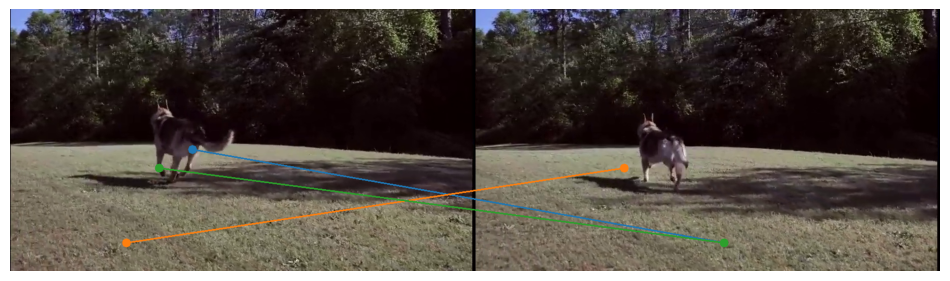

In [ ]:
visualize_time_space(0, 1, 3)